In [ ]:
# Install necessary packages
!pip install -U tensorflow scikit-learn matplotlib pillow opencv-python faiss-cpu sentence-transformers

LIBRARY PACKAGES INSTALLATION

In [ ]:
# Import packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import faiss
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import files
from io import BytesIO
import gc
import re
from ipywidgets import interact, interact_manual
import ipywidgets as widgets
import os

LOADING THE DATASET AND DATA PREPROCESSING

In [ ]:
# DATA PREPARATION WITH METADATA TRACKING

CSV_FILE = 'fashion_mnist_modified_dataset.csv'
IMG_SIZE = (96, 96)

# Load CSV
df = pd.read_csv(CSV_FILE)
print("Dataset loaded:")
print(df.head())
print(f"\nTotal samples: {len(df)}")

# Load and preprocess images from pixel data
def load_images_from_pixels(df, img_size=IMG_SIZE):
    images = []
    pixel_cols = [f'pixel{i}' for i in range(1, 785)]
    for index, row in df.iterrows():
        pixels = row[pixel_cols].values.astype(np.uint8)
        # Reshape and convert to RGB
        img = pixels.reshape(28, 28)  # Original size of Fashion MNIST
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert to RGB
        img = cv2.resize(img, img_size)
        img = img.astype(np.float32) / 255.0
        images.append(img)
    return np.array(images)

# Load images from pixels
print("\n Loading images from pixel data")
images = load_images_from_pixels(df)
print(f" Images loaded: {images.shape}")

# Extract labels and text descriptions
labels = df['label'].values
texts = df['full_description'].values  # Using full_description for text

# Split data with stratification
Ximg_train, Ximg_test, Xtxt_train, Xtxt_test, y_train, y_test, train_idx, test_idx = train_test_split(
    images, texts, labels, np.arange(len(images)),
    test_size=0.2, random_state=42, stratify=labels
)

print(f" Training samples: {len(Ximg_train)}")
print(f" Test samples: {len(Ximg_test)}")


# Category name mapping
category_names = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

# Extract metadata for TRAINING set using train_idx
category_train = [category_names.get(label, f'Class {label}') for label in y_train]
class_name_train = df['class_name'].iloc[train_idx].values
description_train = df['short_description'].iloc[train_idx].values
full_desc_train = df['full_description'].iloc[train_idx].values
price_train = df['price'].iloc[train_idx].values
brand_train = df['brand'].iloc[train_idx].values
color_train = df['color'].iloc[train_idx].values
material_train = df['material'].iloc[train_idx].values
style_train = df['style'].iloc[train_idx].values
gender_train = df['gender'].iloc[train_idx].values  # TO EXTRACT GENDER


print(f"\n Metadata stored for {len(category_train)} training samples")
print(f" Sample product: {category_train[0]}, {brand_train[0]}, ${price_train[0]}")

THE EMBEDDING NETWORK AND PHASES OF MODEL IMPLEMENTATION

In [ ]:
def create_embedding_network(input_shape=(96, 96, 3), embedding_dim=64):
    base = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        pooling='avg',
        weights='imagenet',
        alpha=0.75
    )
    base.trainable = False

    inputs = tf.keras.Input(input_shape)
    x = base(inputs)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(embedding_dim, activation=None)(x)
    outputs = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(outputs)

    return tf.keras.Model(inputs, outputs)



TRIPLET LOSS AND TRIPLET NETWORK

In [ ]:
# Triplet Loss
embedding_dim=64

def triplet_loss(margin=0.5):
    def loss(y_true, y_pred):
        anchor, positive, negative = y_pred[..., :embedding_dim], y_pred[..., embedding_dim:2*embedding_dim], y_pred[..., 2*embedding_dim:]
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
        basic_loss = pos_dist - neg_dist + margin
        loss = tf.maximum(basic_loss, 0.0)
        return tf.reduce_mean(loss)
    return loss

# Data generator for triplets
class TripletGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, labels, batch_size):
        self.images = images
        self.labels = labels
        self.label_to_indices = {label: np.where(labels == label)[0] for label in np.unique(labels)}
        self.batch_size = batch_size
        self.classes = np.unique(labels)

    def __len__(self):
        return len(self.images) // self.batch_size

    def __getitem__(self, idx):
        anchors, positives, negatives = [], [], []
        for _ in range(self.batch_size):
            c = np.random.choice(self.classes)
            anchor_pos = np.random.choice(self.label_to_indices[c], 2, replace=False)
            neg_label = np.random.choice(self.classes[self.classes != c])
            neg = np.random.choice(self.label_to_indices[neg_label])
            anchors.append(self.images[anchor_pos[0]])
            positives.append(self.images[anchor_pos[1]])
            negatives.append(self.images[neg])

        return (np.array(anchors), np.array(positives), np.array(negatives)), np.zeros((self.batch_size, 1))

def create_triplet_model(input_shape, embedding_dim):
    embeddingnet = create_embedding_network(input_shape, embedding_dim)

    anchor_in = tf.keras.Input(input_shape, name='anchor')
    pos_in = tf.keras.Input(input_shape, name='positive')
    neg_in = tf.keras.Input(input_shape, name='negative')

    anc = embeddingnet(anchor_in)
    pos = embeddingnet(pos_in)
    neg = embeddingnet(neg_in)

    merged = tf.keras.layers.concatenate([anc, pos, neg], axis=1)
    model = tf.keras.Model([anchor_in, pos_in, neg_in], merged)

    return model, embeddingnet


# Training the epochs and the model also
batch_size = 16
epochs = 10
triplet_model, embedding_model = create_triplet_model((96,96,3), embedding_dim)
triplet_model.compile(optimizer='adam', loss=triplet_loss(margin=0.5))

triplet_gen = TripletGenerator(Ximg_train, y_train, batch_size)
triplet_model.fit(triplet_gen, epochs=epochs)

FAISS INDEX IMPLEMENTATION

In [ ]:
# Building index
def build_faiss_index(embed_model, imgs):
    embs = embed_model.predict(imgs)
    index = faiss.IndexFlatL2(embs.shape[1])
    index.add(embs.astype('float32'))
    return index, embs

img_index, img_embs = build_faiss_index(embedding_model, Ximg_train)

# Evaluate image-to-image accuracy
def evaluate_image_model(embed_model, imgs, ytrue, img_index, img_labels, topk=5):
    embs = embed_model.predict(imgs)
    D, I = img_index.search(embs.astype('float32'), topk)
    correct = np.sum([ytrue[i] in img_labels[I[i]] for i in range(len(ytrue))])
    acc = correct / len(ytrue) * 100
    #print(f'Image-to-Image Top-{topk} Accuracy: {acc:.2f}%')
    return acc
img_model_acc = evaluate_image_model(embedding_model, Ximg_test, y_test, img_index, y_train, topk=5)


In [ ]:
# Text encoder
text_model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate text embeddings
print("\nGenerating text embeddings...")
txt_embs_train = text_model.encode(
    list(Xtxt_train),
    show_progress_bar=True,
    normalize_embeddings=True,
    convert_to_numpy=True
)

print(f"Text embeddings shape: {txt_embs_train.shape}")

# Getting embedding dimensions
text_embedding_dim = txt_embs_train.shape[1]
image_embedding_dim = img_embs.shape[1]

print(f"\nText embedding dimension: {text_embedding_dim}")
print(f"Image embedding dimension: {image_embedding_dim}")

# Checking if text embedding length matches with the image embedding lengths
if len(txt_embs_train) != len(img_embs):
    print(f"\n WARNING: Mismatch detected!")
    print(f"   Text embeddings: {len(txt_embs_train)} samples")
    print(f"   Image embeddings: {len(img_embs)} samples")

    # Using minimum length to avoid indexing errors
    min_len = min(len(txt_embs_train), len(img_embs))
    txt_embs_train = txt_embs_train[:min_len]
    img_embs_aligned = img_embs[:min_len]
    print(f"   Aligned to: {min_len} samples")
else:
    img_embs_aligned = img_embs
    print(f"\n Embeddings aligned: {len(txt_embs_train)} samples")

# BUILDING MAPPING LAYER

# Improved mapping layer with multiple layers for better learning
mapping_layer = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', name='dense1'),
    tf.keras.layers.Dropout(0.2, name='dropout1'),
    tf.keras.layers.Dense(image_embedding_dim, activation=None, name='output')
], name='text_to_image_mapper')

# Display model architecture
print("\n" + "="*60)
print("MAPPING LAYER ARCHITECTURE:")
mapping_layer.build(input_shape=(None, text_embedding_dim))
mapping_layer.summary()

# COMPILE WITH ANOTHER OPTIMIZER

mapping_layer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# PREPARING TRAINING DATA

# Ensure proper shape for image embeddings
if len(img_embs_aligned.shape) == 1:
    em_train_reshaped = img_embs_aligned.reshape(-1, 1)
elif len(img_embs_aligned.shape) == 2:
    em_train_reshaped = img_embs_aligned
else:
    # Flatten to 2D if needed
    em_train_reshaped = img_embs_aligned.reshape(len(img_embs_aligned), -1)

print(f"\nTraining data shapes:")
print(f"  Input (text): {txt_embs_train.shape}")
print(f"  Output (image): {em_train_reshaped.shape}")

# Verify shapes match
assert txt_embs_train.shape[0] == em_train_reshaped.shape[0], \
    "Number of text and image embeddings must match!"

# TRAIN THE MAPPING LAYER

print("\n" + "="*60)
print("TRAINING TEXT-TO-IMAGE MAPPING LAYER")

# Add callbacks for better training
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='loss',
        factor=0.5,
        patience=2,
        verbose=1,
        min_lr=1e-6
    )
]

# Train the model
history = mapping_layer.fit(
    txt_embs_train,
    em_train_reshaped,
    epochs=20,  # Increased epochs with early stopping
    batch_size=32,
    validation_split=0.1,  # Using 10% for validation
    callbacks=callbacks,
    verbose=1
)

print("\n Training completed!")
print(f"Final training loss: {history.history['loss'][-1]:.4f}")
if 'val_loss' in history.history:
    print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")

In [ ]:
# TEST THE MAPPING

print("\n" + "="*60)
print("TESTING THE MAPPING")

# Test with a sample
test_text = ["blue cotton shirt"]
test_emb = text_model.encode(test_text, normalize_embeddings=True)
test_mapped = mapping_layer.predict(test_emb, verbose=0)

print(f"Input text: {test_text[0]}")
print(f"Text embedding shape: {test_emb.shape}")
print(f"Mapped image embedding shape: {test_mapped.shape}")
print("Mapping works correctly!")

TEXT TO IMAGE MODEL(ADDITIONAL IMPLEMENTATION)

In [ ]:
# STRICT GENDER-AWARE TEXT-TO-IMAGE RECOMMENDATION
def text_to_image_recommendation(query_text, mapping_layer, img_index, topk=5):
    # Normalizing query
    query_lower = query_text.lower().strip()

    # Define strict gender patterns (whole words only)
    male_keywords = r'\b(men|man|boy|male|guy|guys|gentleman|gentlemen|his|he|him)\b'
    female_keywords = r'\b(women|woman|girl|female|lady|ladies|her|she)\b'

    # Detect gender intent
    has_male = bool(re.search(male_keywords, query_lower))
    has_female = bool(re.search(female_keywords, query_lower))

    # Extract category/product keywords (remove gender words)
    category_query = re.sub(male_keywords, '', query_lower)
    category_query = re.sub(female_keywords, '', category_query)
    category_query = category_query.strip()

    # Validate category exists in dataset
    if category_query:
        category_found = False
        category_keywords = category_query.split()

        for cat in category_train:
            cat_lower = str(cat).lower()
            if any(word in cat_lower for word in category_keywords):
                category_found = True
                break

        # Checking descriptions for better coverage
        if not category_found:
            for desc in description_train[:500]:
                desc_lower = str(desc).lower()
                if any(word in desc_lower for word in category_keywords):
                    category_found = True
                    break

        if not category_found:
            print(f"\n{'='*70}")
            print(f" ITEM NOT FOUND")
            print(f"Category/Item '{category_query}' does not exist in the dataset.")
            print(f"\n Available categories include:")
            unique_cats = list(set([str(c).title() for c in category_train[:100]]))[:10]
            for cat in unique_cats:
                print(f"   • {cat}")
            print(f"{'='*70}")
            return None

    # Encode and map query
    q_emb = text_model.encode([query_text], normalize_embeddings=True)
    q_emb_mapped = mapping_layer.predict(q_emb, verbose=0)

    # Determine filter mode
    if has_male and not has_female:
        filter_mode = 'MALE_ONLY'
        print(f"\n{'='*70}")
        print(f" Searching for MEN's items: '{query_text}'")
    elif has_female and not has_male:
        filter_mode = 'FEMALE_ONLY'
        print(f"\n{'='*70}")
        print(f" Searching for WOMEN's items: '{query_text}'")
    elif has_male and has_female:
        filter_mode = 'BOTH'
        print(f"\n{'='*70}")
        print(f" Searching for items (both genders): '{query_text}'")
    else:
        filter_mode = 'NEUTRAL'
        print(f"\n{'='*70}")
        print(f" Searching for items: '{query_text}'")

    # Search larger pool initially
    search_k = min(len(y_train), 1000)
    D, I = img_index.search(q_emb_mapped.astype('float32'), search_k)

    filtered_indices = []

    for idx in I[0]:
        if idx >= len(gender_train):
            continue

        item_gender = str(gender_train[idx]).lower().strip()

        # Categorizing item gender
        is_male_item = bool(re.search(r'\b(men|man|boy|male)\b', item_gender))
        is_female_item = bool(re.search(r'\b(women|woman|girl|female)\b', item_gender))
        is_unisex_item = 'unisex' in item_gender

        include_item = False

        if filter_mode == 'MALE_ONLY':
            if is_male_item and not is_female_item:
                include_item = True

        elif filter_mode == 'FEMALE_ONLY':
            if is_female_item and not is_male_item:
                include_item = True

        elif filter_mode == 'BOTH':
            include_item = True

        elif filter_mode == 'NEUTRAL':
            if is_unisex_item or (not is_male_item and not is_female_item):
                include_item = True

        if include_item:
            filtered_indices.append(idx)

        if len(filtered_indices) >= topk:
            break

    # Handling if there is no results
    if len(filtered_indices) == 0:
        print(f"\n ITEM NOT FOUND")
        print(f"{'='*70}")
        if filter_mode == 'MALE_ONLY':
            print(f"No MEN's items found matching: '{query_text}'")
        elif filter_mode == 'FEMALE_ONLY':
            print(f"No WOMEN's items found matching: '{query_text}'")
        else:
            print(f"No items found matching: '{query_text}'")
        print(f"\n Try different keywords or check available categories.")
        return None

    return filtered_indices[:topk]


# AUTO-GENERATED INTERACTIVE SEARCH INTERFACE

@interact_manual(
    query_text=widgets.Text(
        value='',
        placeholder='Enter search query (e.g., men shoes, women dress)',
        description='Search:',
        layout=widgets.Layout(width='500px')
    ),
    topk=widgets.IntSlider(
        value=5,
        min=1,
        max=10,
        step=1,
        description='Results:',
        layout=widgets.Layout(width='400px')
    )
)
def search_products(query_text, topk):

    if not query_text.strip():
        print(" Please enter a search query!")
        return

    # Get recommendations
    recommended_indices = text_to_image_recommendation(
        query_text, mapping_layer, img_index, topk
    )

    if recommended_indices is None:
        return

    print(f"\n Found {len(recommended_indices)} matching items:")
    print(f"{'='*70}\n")

    # Display products
    num_items = len(recommended_indices)
    fig, axes = plt.subplots(1, num_items, figsize=(4*num_items, 5))

    if num_items == 1:
        axes = [axes]

    for j, idx in enumerate(recommended_indices):
        axes[j].imshow(Ximg_train[idx])

        # Extract product details
        cat = str(category_train[idx])
        desc = str(description_train[idx])
        price = float(price_train[idx]) if idx < len(price_train) else 0.0
        gender = str(gender_train[idx])

        # Format description
        desc_short = desc[:40] + '...' if len(desc) > 40 else desc

        # Create title
        title = f"{cat}\n[{gender}]\n${price:.2f}\n{desc_short}"
        axes[j].set_title(title, fontsize=10, pad=10, fontweight='bold')
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
    print(f"\n{'='*70}")


interactive(children=(Text(value='', description='Search:', layout=Layout(width='500px'), placeholder='Enter s…

CLASSIFIER MODEL IMPLEMENTATION

In [ ]:
# BUILD CLASSIFIER MODEL

num_classes = len(np.unique(y_train))  # infer number of labels

# Freeze base embedding model
embedding_model.trainable = False

# Add classifier head
x = layers.Dense(128, activation='relu')(embedding_model.output)
x = layers.Dropout(0.3)(x)
output = layers.Dense(num_classes, activation='softmax')(x)

classifier_model = tf.keras.Model(inputs=embedding_model.input, outputs=output)

# Compile the classifier
classifier_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(" Classifier model built successfully!")


 Classifier model built successfully!


In [ ]:
print("Training classifier head")
classifier_model.fit(
    Ximg_train, y_train,
    validation_split=0.1,
    epochs=3,
    batch_size=32,
    verbose=1
)


Training classifier head
Epoch 1/3
113/113 ━━━━━━━━━━━━━━━━━━━━ 23s 118ms/step - accuracy: 0.6004 - loss: 1.8626 - val_accuracy: 0.8825 - val_loss: 0.6717
Epoch 2/3
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8594 - loss: 0.5894 - val_accuracy: 0.8825 - val_loss: 0.3763
Epoch 3/3
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8671 - loss: 0.4140 - val_accuracy: 0.8850 - val_loss: 0.3411


In [ ]:
def predict_image_class(image, model, category_names):
    img_array = np.expand_dims(image, axis=0) # Add batch dimension
    embedding = model.predict(img_array, verbose=0)
    # Find the closest embedding in the training set
    D, I = img_index.search(embedding.astype('float32'), 1) # Search for the single closest match
    predicted_label = y_train[I[0][0]]
    predicted_class_name = category_names.get(predicted_label, f'Class {predicted_label}')
    return predicted_class_name

IMAGE TO IMAGE SIMILIARITY SEARCH AND RECOMMENDATION SYSTEM(AS PER PROBLEM STATEMENT 6)

UPLOAD YOUR OWN IMAGES FOR VISUAL RECOMMENDATION


Saving DRESS_1.jpeg to DRESS_1.jpeg


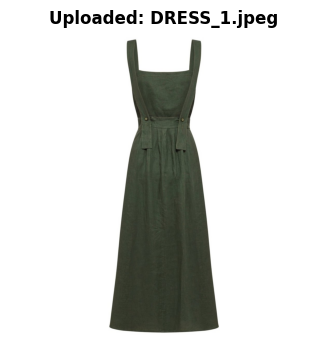

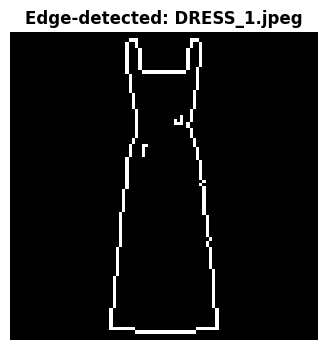


 Top 5 recommended products similar to 'Dress':


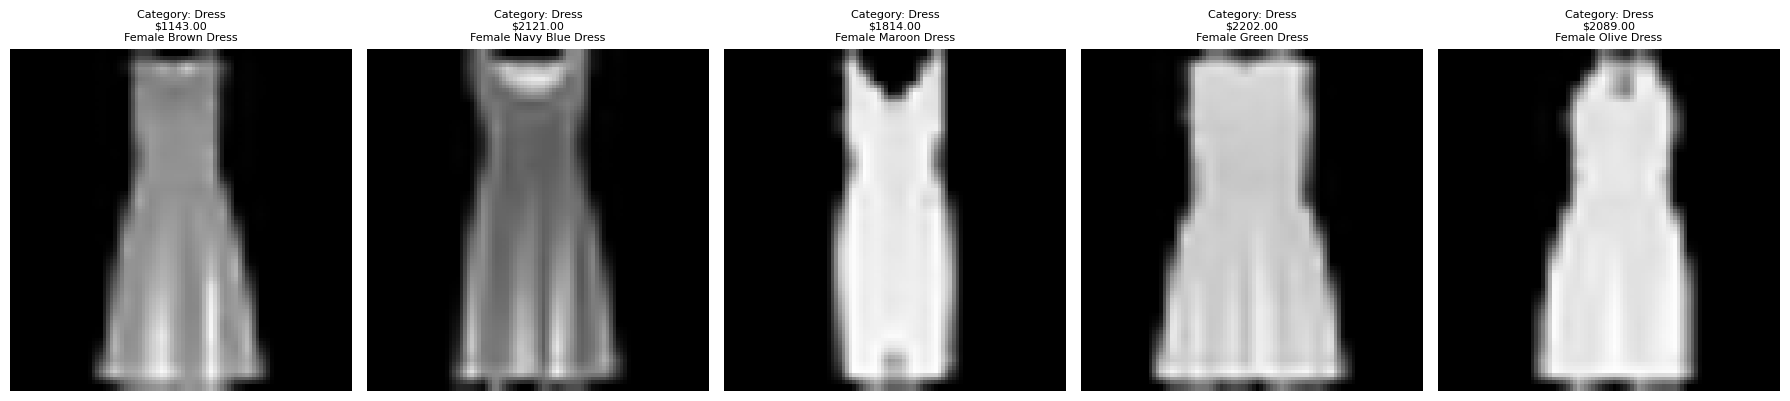


Detailed Product Information:

1. Similarity Score: 0.1798
   Category: Dress
   Price: $1143.00
   Description: Female Brown Dress

2. Similarity Score: 0.1931
   Category: Dress
   Price: $2121.00
   Description: Female Navy Blue Dress

3. Similarity Score: 0.2026
   Category: Dress
   Price: $1814.00
   Description: Female Maroon Dress

4. Similarity Score: 0.2089
   Category: Dress
   Price: $2202.00
   Description: Female Green Dress

5. Similarity Score: 0.2108
   Category: Dress
   Price: $2089.00
   Description: Female Olive Dress


In [ ]:
# INTERACTIVE IMAGE UPLOAD FOR RECOMMENDATIONS

# Define class name mapping
class_labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

try:
    classifier_model
except NameError:
    classifier_model = embedding_model

print("="*60)
print("UPLOAD YOUR OWN IMAGES FOR VISUAL RECOMMENDATION")
uploaded = files.upload()  # User uploads image (JPG, PNG)

topk = 5  # Number of recommendations

for filename in uploaded.keys():
    imgfile = Image.open(BytesIO(uploaded[filename]))
    if imgfile.mode != 'RGB':
        imgfile = imgfile.convert('RGB')
    arr = np.array(imgfile)

    # Display uploaded image
    plt.figure(figsize=(4,4))
    plt.imshow(arr)
    plt.axis('off')
    plt.title(f"Uploaded: {filename}", fontsize=12, fontweight='bold')
    plt.show()

    # Preprocess image
    userimg = cv2.resize(arr, IMG_SIZE)
    userimg = userimg.astype(np.float32) / 255.0
    userimg = np.expand_dims(userimg, 0)

    # Predict class
    try:
        # Convert to NumPy before resizing
        user_img_processed = np.array(imgfile)
        user_img_processed = cv2.resize(user_img_processed, IMG_SIZE)
        user_img_processed = user_img_processed.astype(np.float32) / 255.0

        # Predict the class using the trained classifier model
        preds = classifier_model.predict(np.expand_dims(user_img_processed, 0), verbose=0)
        pred_class = np.argmax(preds, axis=1)[0]
        class_name = class_labels.get(pred_class, "Unknown")

    except Exception as e:
        print(f" Could not predict class: {e}")
        class_name = "Unknown"


    # Edge detection visualization
    edges = cv2.Canny((userimg[0] * 255).astype(np.uint8), 100, 200)
    plt.figure(figsize=(4,4))
    plt.imshow(edges, cmap='gray')
    plt.axis('off')
    plt.title(f"Edge-detected: {filename}", fontsize=12, fontweight='bold')
    plt.show()

    # Get embedding and search for recommendations
    user_embedding = embedding_model.predict(userimg, verbose=0)
    D, I = img_index.search(user_embedding.astype('float32'), topk)

    # Display recommendations with product details
    print(f"\n Top {topk} recommended products similar to '{class_name}':")
    print("="*60)

    fig, axes = plt.subplots(1, topk, figsize=(18, 4))
    for j, idx in enumerate(I[0]):
        axes[j].imshow(Ximg_train[idx])

        cat = category_train[idx] if idx < len(category_train) else 'Unknown'
        desc = description_train[idx] if idx < len(description_train) else 'No description'
        price = price_train[idx] if idx < len(price_train) else 0.0
        desc_short = desc[:30] + '...' if len(str(desc)) > 30 else desc

        title = f"Category: {cat}\n${price:.2f}\n{desc_short}"
        axes[j].set_title(title, fontsize=8)
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

    # Print detailed info
    print("\nDetailed Product Information:")
    for j, idx in enumerate(I[0]):
        print(f"\n{j+1}. Similarity Score: {D[0][j]:.4f}")
        print(f"   Category: {category_train[idx]}")
        print(f"   Price: ${price_train[idx]:.2f}")
        print(f"   Description: {description_train[idx]}")


GENDER-SPECIFIC IMAGE TO IMAGE SIMILIARITY SEARCH AND RECOMMENDATION SYSTEM(ADDITIONAL ADVANCEMENT IMPLEMENTATION )

UPLOAD YOUR OWN IMAGES FOR VISUAL RECOMMENDATION


Saving BAG1.jpeg to BAG1.jpeg

 Processing: BAG1.jpeg


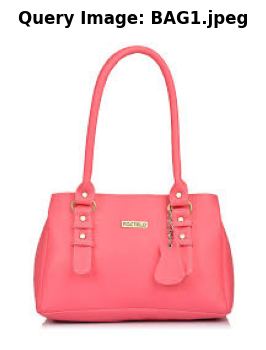

Predicted Class: Bag


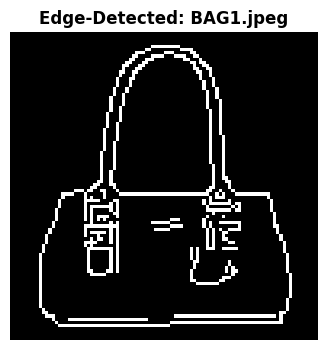

SELECT RECOMMENDATION MODE
1. Similarity-Based Only (pure visual similarity)
2. Strict Gender-Specific (similarity with strict gender filtering)
Enter your choice (1 or 2): 2

SELECT GENDER PREFERENCE:
------------------------------------------------------------
1. Men (shows Men + Unisex products only)
2. Female (shows Female + Unisex products only)
3. Unisex (shows all Unisex products only)
------------------------------------------------------------
Enter your choice (1, 2, or 3): 2
 Selected: Female + Unisex category products

RECOMMENDATIONS (Strict Filter: FEMALE + UNISEX)


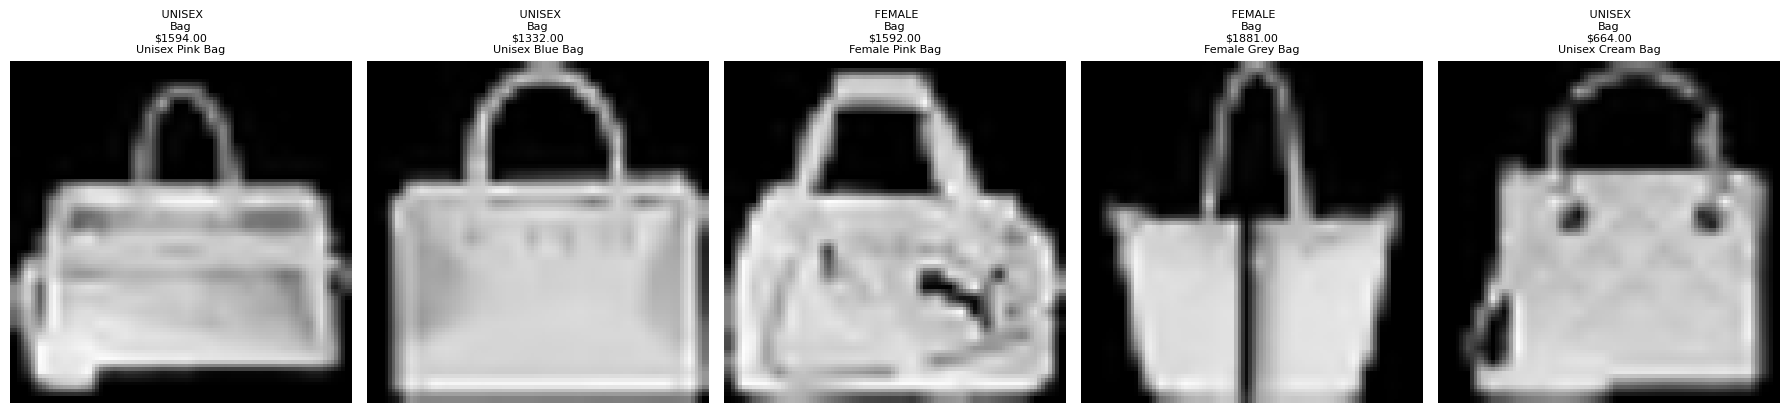


DETAILED PRODUCT INFORMATION:
------------------------------------------------------------

1. Similarity Score: 0.6937
   Category: Bag
   Gender: UNISEX
   Price: $1594.00
   Description: Unisex Pink Bag

2. Similarity Score: 0.6916
   Category: Bag
   Gender: UNISEX
   Price: $1332.00
   Description: Unisex Blue Bag

3. Similarity Score: 0.6804
   Category: Bag
   Gender: FEMALE
   Price: $1592.00
   Description: Female Pink Bag

4. Similarity Score: 0.6755
   Category: Bag
   Gender: FEMALE
   Price: $1881.00
   Description: Female Grey Bag

5. Similarity Score: 0.6720
   Category: Bag
   Gender: UNISEX
   Price: $664.00
   Description: Unisex Cream Bag

 Recommendations complete for: BAG1.jpeg

 All images processed!


In [ ]:
# STRICT GENDER-SPECIFIC RECOMMENDATION SYSTEM

def get_recommendation_mode():
    print("SELECT RECOMMENDATION MODE")
    print("="*60)
    print("1. Similarity-Based Only (pure visual similarity)")
    print("2. Strict Gender-Specific (similarity with strict gender filtering)")
    print("="*60)

    while True:
        try:
            choice = input("Enter your choice (1 or 2): ").strip()
            if choice == "1":
                return "similarity_only", None
            elif choice == "2":
                return "strict_gender_filtering", get_gender_preference()
            else:
                print("Invalid choice. Please enter 1 or 2.")
        except Exception as e:
            print(f"Error: {e}. Please try again.")


def get_gender_preference():
    print("\nSELECT GENDER PREFERENCE:")
    print("-" * 60)
    print("1. Men (shows Men + Unisex products only)")
    print("2. Female (shows Female + Unisex products only)")
    print("3. Unisex (shows all Unisex products only)")
    print("-" * 60)

    while True:
        try:
            choice = input("Enter your choice (1, 2, or 3): ").strip()
            if choice == "1":
                print(" Selected: Men + Unisex category products")
                return "men"
            elif choice == "2":
                print(" Selected: Female + Unisex category products")
                return "female"
            elif choice == "3":
                print(" Selected: Unisex category products only")
                return "unisex"
            else:
                print("Invalid choice. Please enter 1, 2, or 3.")
        except Exception as e:
            print(f"Error: {e}. Please try again.")


def apply_strict_gender_filtering(indices, similarities, genders, target_gender):

    valid_items = []

    for i, idx in enumerate(indices):
        if idx >= len(genders):
            continue

        item_gender = str(genders[idx]).lower().strip()

        # Strict filtering logic
        if target_gender.lower() == 'men':
            # Accept only male or unisex items
            if item_gender in ['men', 'unisex']:
                valid_items.append((idx, similarities[i]))

        elif target_gender.lower() == 'female':
            # Accept only female or unisex items
            if item_gender in ['female', 'unisex']:
                valid_items.append((idx, similarities[i]))

        elif target_gender.lower() == 'unisex':
            # Accept only unisex items
            if item_gender == 'unisex':
                valid_items.append((idx, similarities[i]))

    # Sort by similarity score (descending)
    valid_items.sort(key=lambda x: x[1], reverse=True)

    # Separate indices and similarities
    if valid_items:
        filtered_indices = np.array([item[0] for item in valid_items])
        filtered_similarities = np.array([item[1] for item in valid_items])
    else:
        filtered_indices = np.array([])
        filtered_similarities = np.array([])

    return filtered_indices, filtered_similarities


def display_recommendations(query_filename, query_image, pred_class, class_name,
                           similarities, indices, topk,
                           mode="similarity_only", target_gender=None):

    # Check if we have any recommendations
    if len(indices) == 0:
        print("\n" + "="*60)
        print(f" NO MATCHING PRODUCTS FOUND FOR {target_gender.upper()} CATEGORY")
        print("="*60)
        print("\nTry:")
        print("1. Using a different gender filter")
        print("2. Switching to similarity-based mode")
        return

    # Display mode information
    if mode == "similarity_only":
        print(f"\nRECOMMENDATIONS (Similarity-Based Only)")
    else:
        gender_display = f"{target_gender.upper()} + UNISEX" if target_gender != "unisex" else "UNISEX ONLY"
        print(f"\nRECOMMENDATIONS (Strict Filter: {gender_display})")
    print("="*60)

    # Adjust topk if we have fewer items
    actual_topk = min(topk, len(indices))

    if actual_topk < topk:
        print(f" Only {actual_topk} matching products found (requested {topk})")
        print("-"*60)

    # Display recommendations in grid
    fig, axes = plt.subplots(1, actual_topk, figsize=(3.6 * actual_topk, 4))

    # Handle single item case
    if actual_topk == 1:
        axes = [axes]

    # Ensure indices is a flat array for iteration
    flat_indices = indices.flatten() if indices.ndim > 1 else indices

    for j in range(actual_topk):
        idx = flat_indices[j]

        if idx >= len(Ximg_train):
            print(f"Warning: Index {idx} out of bounds for Ximg_train.")
            continue

        axes[j].imshow(Ximg_train[idx])

        cat = category_train[idx] if idx < len(category_train) else 'Unknown'
        desc = description_train[idx] if idx < len(description_train) else 'No description'
        price = price_train[idx] if idx < len(price_train) else 0.0
        gender = gender_train[idx] if idx < len(gender_train) else 'Unknown'
        desc_short = desc[:25] + '...' if len(str(desc)) > 25 else desc

        # Include gender info in title with emoji indicators
        title = f" {gender.upper()}\n{cat}\n${price:.2f}\n{desc_short}"
        axes[j].set_title(title, fontsize=8)
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

    # Display detailed information
    print("\nDETAILED PRODUCT INFORMATION:")
    print("-" * 60)

    for j in range(actual_topk):
        idx = flat_indices[j]

        if idx >= len(Ximg_train):
            continue

        similarity_score = similarities[j]
        cat = category_train[idx] if idx < len(category_train) else 'Unknown'
        price = price_train[idx] if idx < len(price_train) else 0.0
        desc = description_train[idx] if idx < len(description_train) else 'No description'
        gender = gender_train[idx] if idx < len(gender_train) else 'Unknown'

        print(f"\n{j+1}. Similarity Score: {similarity_score:.4f}")
        print(f"   Category: {cat}")
        print(f"   Gender: {gender.upper()}")
        print(f"   Price: ${price:.2f}")
        print(f"   Description: {desc}")



# MAIN INTERACTIVE UPLOAD SECTION


print("UPLOAD YOUR OWN IMAGES FOR VISUAL RECOMMENDATION")
print("="*60)

uploaded = files.upload()  # User uploads image (JPG, PNG)

topk = 5  # Number of recommendations

for filename in uploaded.keys():
    print(f"\n Processing: {filename}")

    # Load and process image
    imgfile = Image.open(BytesIO(uploaded[filename]))
    if imgfile.mode != 'RGB':
        imgfile = imgfile.convert('RGB')
    arr = np.array(imgfile)

    # Display uploaded image
    plt.figure(figsize=(4, 4))
    plt.imshow(arr)
    plt.axis('off')
    plt.title(f"Query Image: {filename}", fontsize=12, fontweight='bold')
    plt.show()

    # Preprocess image
    userimg = cv2.resize(arr, IMG_SIZE)
    userimg = userimg.astype(np.float32) / 255.0
    userimg = np.expand_dims(userimg, 0)

    # Predict class
    try:
        user_img_processed = np.array(imgfile)
        user_img_processed = cv2.resize(user_img_processed, IMG_SIZE)
        user_img_processed = user_img_processed.astype(np.float32) / 255.0

        # Predict the class using the trained classifier model
        preds = classifier_model.predict(np.expand_dims(user_img_processed, 0), verbose=0)
        pred_class = np.argmax(preds, axis=1)[0]
        class_name = class_labels.get(pred_class, "Unknown")

        print(f"Predicted Class: {class_name}")

    except Exception as e:
        print(f" Could not predict class: {e}")
        class_name = "Unknown"

    # Edge detection visualization
    edges = cv2.Canny((userimg[0] * 255).astype(np.uint8), 100, 200)
    plt.figure(figsize=(4, 4))
    plt.imshow(edges, cmap='gray')
    plt.axis('off')
    plt.title(f"Edge-Detected: {filename}", fontsize=12, fontweight='bold')
    plt.show()

    # GET RECOMMENDATION MODE FROM USER
    mode, target_gender = get_recommendation_mode()

    # Get embedding and search for recommendations
    user_embedding = embedding_model.predict(userimg, verbose=0)

    # Get MORE candidates for strict filtering (3x to ensure enough matches)
    search_size = topk * 3 if mode == "strict_gender_filtering" else topk
    D, I = img_index.search(user_embedding.astype('float32'), search_size)

    # APPLY STRICT GENDER FILTERING IF SELECTED
    if mode == "strict_gender_filtering":
        # Apply strict gender filtering
        filtered_indices, filtered_similarities = apply_strict_gender_filtering(
            I[0],  # Pass indices
            D[0],  # Pass similarities
            gender_train,  # Pass genders
            target_gender
        )

        # Take top-k from filtered results
        final_topk = min(topk, len(filtered_indices))
        final_I = filtered_indices[:final_topk]
        final_D = filtered_similarities[:final_topk]

        # Creating 2D arrays for consistency with display function
        D_display = final_D
        I_display = final_I
    else:
        # Use original similarities
        D_display = D[0, :topk]
        I_display = I[0, :topk]

    # Display recommendations with product details
    display_recommendations(
        query_filename=filename,
        query_image=arr,
        pred_class=pred_class,
        class_name=class_name,
        similarities=D_display,
        indices=I_display,
        topk=topk,
        mode=mode,
        target_gender=target_gender
    )

    print("\n" + "="*60)
    print(f" Recommendations complete for: {filename}")

print("\n All images processed!")

EVALUATION METRICES

MODEL ACCURACY EVALUATION

COMPUTING TOP-K METRICS
------------------------------------------------------------
Top-1: Img Acc=82.50% | Txt Acc=99.10%
Top-3: Img Acc=91.40% | Txt Acc=99.10%
Top-5: Img Acc=93.10% | Txt Acc=99.10%
Top-7: Img Acc=95.20% | Txt Acc=99.10%
Top-9: Img Acc=95.70% | Txt Acc=99.10%


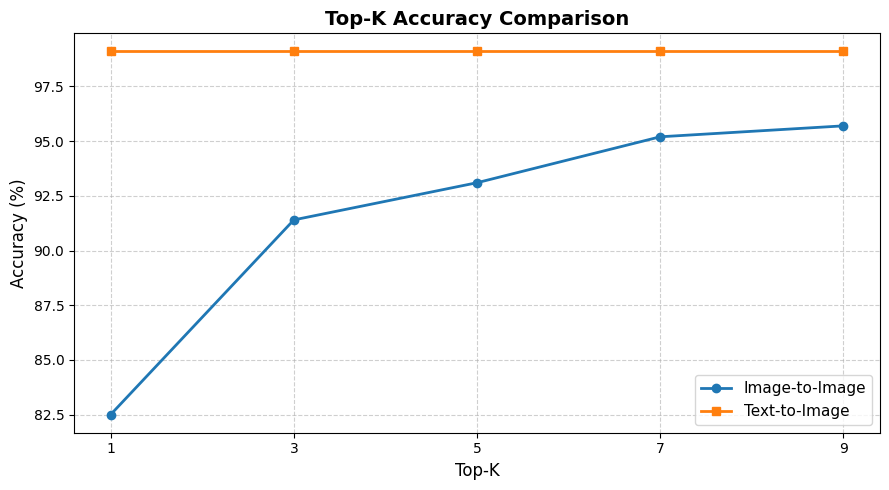

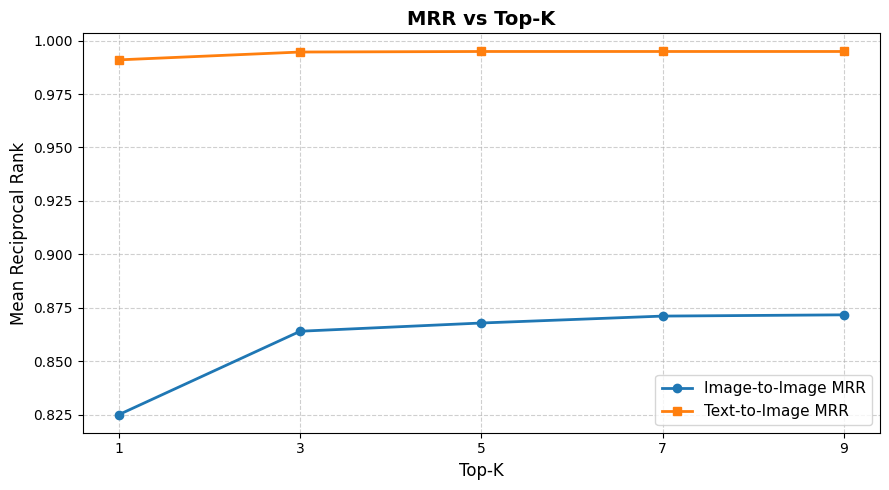


 Evaluation Complete!


In [ ]:
# COMPREHENSIVE ACCURACY EVALUATION
print("="*70)
print("MODEL ACCURACY EVALUATION")





def evaluate_text_to_image_detailed(Xtxt, ytxt, mapping_layer, img_index, img_labels, topk=5):
    """Evaluate text-to-image model with multiple metrics"""
    # Top-K accuracy
    correct_topk = 0
    correct_top1 = 0
    mrr = 0

    for i, text in enumerate(Xtxt):
        q_emb = text_model.encode([text], normalize_embeddings=True)
        q_emb_mapped = mapping_layer.predict(q_emb, verbose=0)
        D, I = img_index.search(q_emb_mapped.astype('float32'), topk)

        # Top-K
        if ytxt[i] in img_labels[I[0]]:
            correct_topk += 1

        # Top-1
        if ytxt[i] == img_labels[I[0][0]]:
            correct_top1 += 1

        # MRR
        for rank, idx in enumerate(I[0]):
            if ytxt[i] == img_labels[idx]:
                mrr += 1.0 / (rank + 1)
                break

    acc_top1 = correct_top1 / len(Xtxt) * 100
    acc_topk = correct_topk / len(Xtxt) * 100
    mrr = mrr / len(Xtxt)

    return acc_top1, acc_topk, mrr

txt_acc_top1, txt_acc_top5, txt_mrr = evaluate_text_to_image_detailed(
    Xtxt_test, y_test, mapping_layer, img_index, y_train, topk=5
)





def compute_topk_accuracy(embed_model, imgs, ytrue, img_index, img_labels, k):
    embs = embed_model.predict(imgs, verbose=0)
    D, I = img_index.search(embs.astype('float32'), k)

    correct = 0
    for i in range(len(ytrue)):
        if ytrue[i] in img_labels[I[i]]:
            correct += 1

    return (correct / len(ytrue)) * 100


def compute_mrr(embed_model, imgs, ytrue, img_index, img_labels, k):
    embs = embed_model.predict(imgs, verbose=0)
    D, I = img_index.search(embs.astype('float32'), k)

    mrr = 0
    for i in range(len(ytrue)):
        for rank, idx in enumerate(I[i]):
            if ytrue[i] == img_labels[idx]:
                mrr += 1.0 / (rank + 1)
                break

    return mrr / len(ytrue)
topk_values = [1, 3, 5, 7, 9]

img_topk_acc = []
txt_topk_acc = []

img_mrr_values = []
txt_mrr_values = []

print("\nCOMPUTING TOP-K METRICS")
print("-" * 60)

for k in topk_values:
    # Image-to-Image
    img_acc = compute_topk_accuracy(
        embedding_model,
        Ximg_test,
        y_test,
        img_index,
        y_train,
        k
    )
    img_topk_acc.append(img_acc)

    img_mrr = compute_mrr(
        embedding_model,
        Ximg_test,
        y_test,
        img_index,
        y_train,
        k
    )
    img_mrr_values.append(img_mrr)

    # Text-to-Image
    txt_acc, _, txt_mrr = evaluate_text_to_image_detailed(
        Xtxt_test,
        y_test,
        mapping_layer,
        img_index,
        y_train,
        topk=k
    )

    txt_topk_acc.append(txt_acc)
    txt_mrr_values.append(txt_mrr)

    print(f"Top-{k}: Img Acc={img_acc:.2f}% | Txt Acc={txt_acc:.2f}%")
plt.figure(figsize=(9, 5))

plt.plot(
    topk_values,
    img_topk_acc,
    marker='o',
    linewidth=2,
    label='Image-to-Image'
)

plt.plot(
    topk_values,
    txt_topk_acc,
    marker='s',
    linewidth=2,
    label='Text-to-Image'
)

plt.xlabel("Top-K", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.title("Top-K Accuracy Comparison", fontsize=14, fontweight='bold')

plt.xticks(topk_values)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=11)

plt.tight_layout()
plt.show()
plt.figure(figsize=(9, 5))

plt.plot(
    topk_values,
    img_mrr_values,
    marker='o',
    linewidth=2,
    label='Image-to-Image MRR'
)

plt.plot(
    topk_values,
    txt_mrr_values,
    marker='s',
    linewidth=2,
    label='Text-to-Image MRR'
)

plt.xlabel("Top-K", fontsize=12)
plt.ylabel("Mean Reciprocal Rank", fontsize=12)
plt.title("MRR vs Top-K", fontsize=14, fontweight='bold')

plt.xticks(topk_values)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=11)

plt.tight_layout()
plt.show()

print("\n Evaluation Complete!")
